# Data Science Intern @Lets Grow More
Author: Nikita Kumbhar.

Task 3 : Music Recommendation 

 Dataset : //www.kaggle.com/c/kkbox-music-recommendation-challenge/data

# **Importing library**

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

In [2]:
import string
import math
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

import lightgbm as lgbm
import xgboost as xgb
import catboost as cb

In [4]:
!pip install py7zr
import py7zr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.6/93.6 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.6/138.6 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 33.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.2/384.2 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.2/357.2 kB 23.4 MB/s eta 0:00:00


In [6]:
archive1=py7zr.SevenZipFile('../input/kkbox-music-recommendation-challenge/songs.csv.7z', mode='r')
archive1.extractall(path="/kaggle/temp")

archive2=py7zr.SevenZipFile('../input/kkbox-music-recommendation-challenge/song_extra_info.csv.7z', mode='r')
archive2.extractall(path="/kaggle/temp")

archive3=py7zr.SevenZipFile('../input/kkbox-music-recommendation-challenge/members.csv.7z', mode='r')
archive3.extractall(path="/kaggle/temp")

archive4=py7zr.SevenZipFile('../input/kkbox-music-recommendation-challenge/test.csv.7z', mode='r')
archive4.extractall(path="/kaggle/temp")

archive5=py7zr.SevenZipFile('../input/kkbox-music-recommendation-challenge/train.csv.7z', mode='r')
archive5.extractall(path="/kaggle/temp")

In [7]:
import os
os.listdir('/kaggle/temp/')


['songs.csv', 'song_extra_info.csv', 'members.csv', 'train.csv', 'test.csv']

In [8]:
songs_df = pd.read_csv("/kaggle/temp/songs.csv")
song_extra_df = pd.read_csv('/kaggle/temp/song_extra_info.csv')
members_df = pd.read_csv("/kaggle/temp/members.csv")
train_df = pd.read_csv("/kaggle/temp/train.csv", nrows = 100000)

In [9]:
#It show 1st five records
songs_df.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [10]:
song_extra_df.head()

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001


In [11]:
members_df.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


In [12]:
train_df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [14]:
#It show last five records
train_df.tail()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
99995,EedNarOVNUU5ppYW/ho+KV8V29zuf7m3+Df5qnQ9FT4=,c7bvJHblBfQGFJG+DcltwclubmlYvIRTT964Lu4WWXI=,my library,Local playlist more,local-playlist,1
99996,xyxz9lf8ipoxELeDLlazmHVZHE1ZYqE6iwfJWkH3Ojc=,MZTwICqr12ijCeBaWeKVJZ67Bz7NI0WA4bqB1IwR4jI=,my library,Local playlist more,local-library,0
99997,vDi/nHqBu7wb+DtI2Ix4TupWQatUEFR41mDC0c8Voh8=,xK0clTH8TvjG6sKmJXZuMLzhikhlEsolLtx2AHBpmbQ=,my library,Local playlist more,local-library,1
99998,xyxz9lf8ipoxELeDLlazmHVZHE1ZYqE6iwfJWkH3Ojc=,SoPkcfpiBjDpZSNPN3HdbPI8WAkuenayPXyBRK91T2s=,my library,Local playlist more,local-library,0
99999,n8TgRhOBw+DthR6N6ie/63yp3KHA20UVHlbK9nY9nIc=,PEEg0ODi9cPg1VXM9EOhZtV39sBJFr/9cIflhbHJ5Bs=,my library,Local playlist more,local-library,1


In [15]:
merge_1 = pd.merge(train_df, songs_df, on = 'song_id', how = 'left')
merge_2 = pd.merge(merge_1, song_extra_df, on = 'song_id', how = 'left')
songs = pd.merge(merge_2, members_df, on = 'msno', how = 'left')
del train_df, songs_df, song_extra_df, members_df, merge_1, merge_2
songs.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471.0,359,Bastille,Dan Smith| Mark Crew,NaN,52.0,Good Grief,GBUM71602854,1,0,NaN,7,20120102,20171005
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584.0,1259,Various Artists,NaN,NaN,52.0,Lords of Cardboard,US3C69910183,13,24,female,9,20110525,20170911
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,NaN,52.0,Hip Hop Is Dead(Album Version (Edited)),USUM70618761,13,24,female,9,20110525,20170911
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,255512.0,1019,Soundway,Kwadwo Donkoh,NaN,-1.0,Disco Africa,GBUQH1000063,13,24,female,9,20110525,20170911
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,NaN,52.0,Sleep Without You,QM3E21606003,1,0,NaN,7,20120102,20171005


In [16]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   msno                    100000 non-null  object 
 1   song_id                 100000 non-null  object 
 2   source_system_tab       99697 non-null   object 
 3   source_screen_name      95727 non-null   object 
 4   source_type             99805 non-null   object 
 5   target                  100000 non-null  int64  
 6   song_length             99996 non-null   float64
 7   genre_ids               98498 non-null   object 
 8   artist_name             99996 non-null   object 
 9   composer                78528 non-null   object 
 10  lyricist                59309 non-null   object 
 11  language                99996 non-null   float64
 12  name                    99991 non-null   object 
 13  isrc                    91475 non-null   object 
 14  city                 

In [18]:
songs.shape

(100000, 20)

**In this dataset 100000 rows and 20 columns.**

In [17]:
songs.isna().sum()

msno                          0
song_id                       0
source_system_tab           303
source_screen_name         4273
source_type                 195
target                        0
song_length                   4
genre_ids                  1502
artist_name                   4
composer                  21472
lyricist                  40691
language                      4
name                          9
isrc                       8525
city                          0
bd                            0
gender                    38672
registered_via                0
registration_init_time        0
expiration_date               0
dtype: int64

**We see lots of missing value present in dataset. so remove these missing value.**

In [19]:
# Fill missing values
for i in songs.select_dtypes(include=['object']).columns:
    songs[i][songs[i].isnull()] = 'unknown'
songs.fillna(value = 0).tail()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date
99995,EedNarOVNUU5ppYW/ho+KV8V29zuf7m3+Df5qnQ9FT4=,c7bvJHblBfQGFJG+DcltwclubmlYvIRTT964Lu4WWXI=,my library,Local playlist more,local-playlist,1,236982.0,465,2NE1,unknown,unknown,31.0,I Love You,TWA531200396,14,0,unknown,9,20150321,20170923
99996,xyxz9lf8ipoxELeDLlazmHVZHE1ZYqE6iwfJWkH3Ojc=,MZTwICqr12ijCeBaWeKVJZ67Bz7NI0WA4bqB1IwR4jI=,my library,Local playlist more,local-library,0,228241.0,465,One Direction,Wayne Hector| John Ryan| Julian Bunetta| Ed Dr...,Wayne Hector| John Ryan| Julian Bunetta| Ed Dr...,52.0,Steal My Girl,GBHMU1400159,1,0,unknown,7,20120117,20171004
99997,vDi/nHqBu7wb+DtI2Ix4TupWQatUEFR41mDC0c8Voh8=,xK0clTH8TvjG6sKmJXZuMLzhikhlEsolLtx2AHBpmbQ=,my library,Local playlist more,local-library,1,196812.0,465,Michael Giacchino,Mikkel Eriksen|Sia Furler|Tor Erik Hermansen,unknown,52.0,Try Everything,USWD11575402,13,0,unknown,9,20110322,20180403
99998,xyxz9lf8ipoxELeDLlazmHVZHE1ZYqE6iwfJWkH3Ojc=,SoPkcfpiBjDpZSNPN3HdbPI8WAkuenayPXyBRK91T2s=,my library,Local playlist more,local-library,0,215775.0,465,Katy Perry,Katy Perry| Max Martin| Jordan Houston| Lukasz...,unknown,52.0,Dark Horse,USUM71311296,1,0,unknown,7,20120117,20171004
99999,n8TgRhOBw+DthR6N6ie/63yp3KHA20UVHlbK9nY9nIc=,PEEg0ODi9cPg1VXM9EOhZtV39sBJFr/9cIflhbHJ5Bs=,my library,Local playlist more,local-library,1,191425.0,465,孫盛希 (Shi Shi),孫盛希,孫盛希,3.0,你的誰,TWA451499001,1,0,unknown,7,20150706,20170921


In [20]:
songs.isna().sum()

msno                      0
song_id                   0
source_system_tab         0
source_screen_name        0
source_type               0
target                    0
song_length               4
genre_ids                 0
artist_name               0
composer                  0
lyricist                  0
language                  4
name                      0
isrc                      0
city                      0
bd                        0
gender                    0
registered_via            0
registration_init_time    0
expiration_date           0
dtype: int64

In [ ]:
#Extracting Features 

In [22]:
# registration_init_time
songs.registration_init_time = pd.to_datetime(songs.registration_init_time, format='%Y%m%d', errors='ignore')
songs['registration_init_time_year'] = songs['registration_init_time'].dt.year
songs['registration_init_time_month'] = songs['registration_init_time'].dt.month
songs['registration_init_time_day'] = songs['registration_init_time'].dt.day

# expiration_date
songs.expiration_date = pd.to_datetime(songs.expiration_date,  format='%Y%m%d', errors='ignore')
songs['expiration_date_year'] = songs['expiration_date'].dt.year
songs['expiration_date_month'] = songs['expiration_date'].dt.month
songs['expiration_date_day'] = songs['expiration_date'].dt.day

In [23]:
songs.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471.0,359,Bastille,Dan Smith| Mark Crew,unknown,52.0,Good Grief,GBUM71602854,1,0,unknown,7,2012-01-02,2017-10-05,2012,1,2,2017,10,5
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584.0,1259,Various Artists,unknown,unknown,52.0,Lords of Cardboard,US3C69910183,13,24,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,unknown,52.0,Hip Hop Is Dead(Album Version (Edited)),USUM70618761,13,24,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,255512.0,1019,Soundway,Kwadwo Donkoh,unknown,-1.0,Disco Africa,GBUQH1000063,13,24,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,unknown,52.0,Sleep Without You,QM3E21606003,1,0,unknown,7,2012-01-02,2017-10-05,2012,1,2,2017,10,5


In [24]:
label_encoder = LabelEncoder()
one_hot = OneHotEncoder()

for i in songs.columns :
    songs[i] = label_encoder.fit_transform(songs[i])

In [25]:
songs.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,1647,6022,1,6,5,1,3513,94,424,1615,3159,8,3900,3293,0,1,2,2,1176,328,8,0,1,4,9,4
1,3471,18027,3,7,4,1,8945,28,3757,7664,3159,8,6186,18561,11,14,0,3,974,304,7,4,24,4,8,10
2,3471,9744,3,7,4,1,4972,28,2550,5137,3159,8,4359,21796,11,14,0,3,974,304,7,4,24,4,8,10
3,3471,1868,3,7,4,1,7193,1,3231,4202,3159,0,2685,3322,11,14,0,3,974,304,7,4,24,4,8,10
4,1647,2688,1,6,5,1,2329,0,561,970,3159,8,9286,8761,0,1,2,2,1176,328,8,0,1,4,9,4


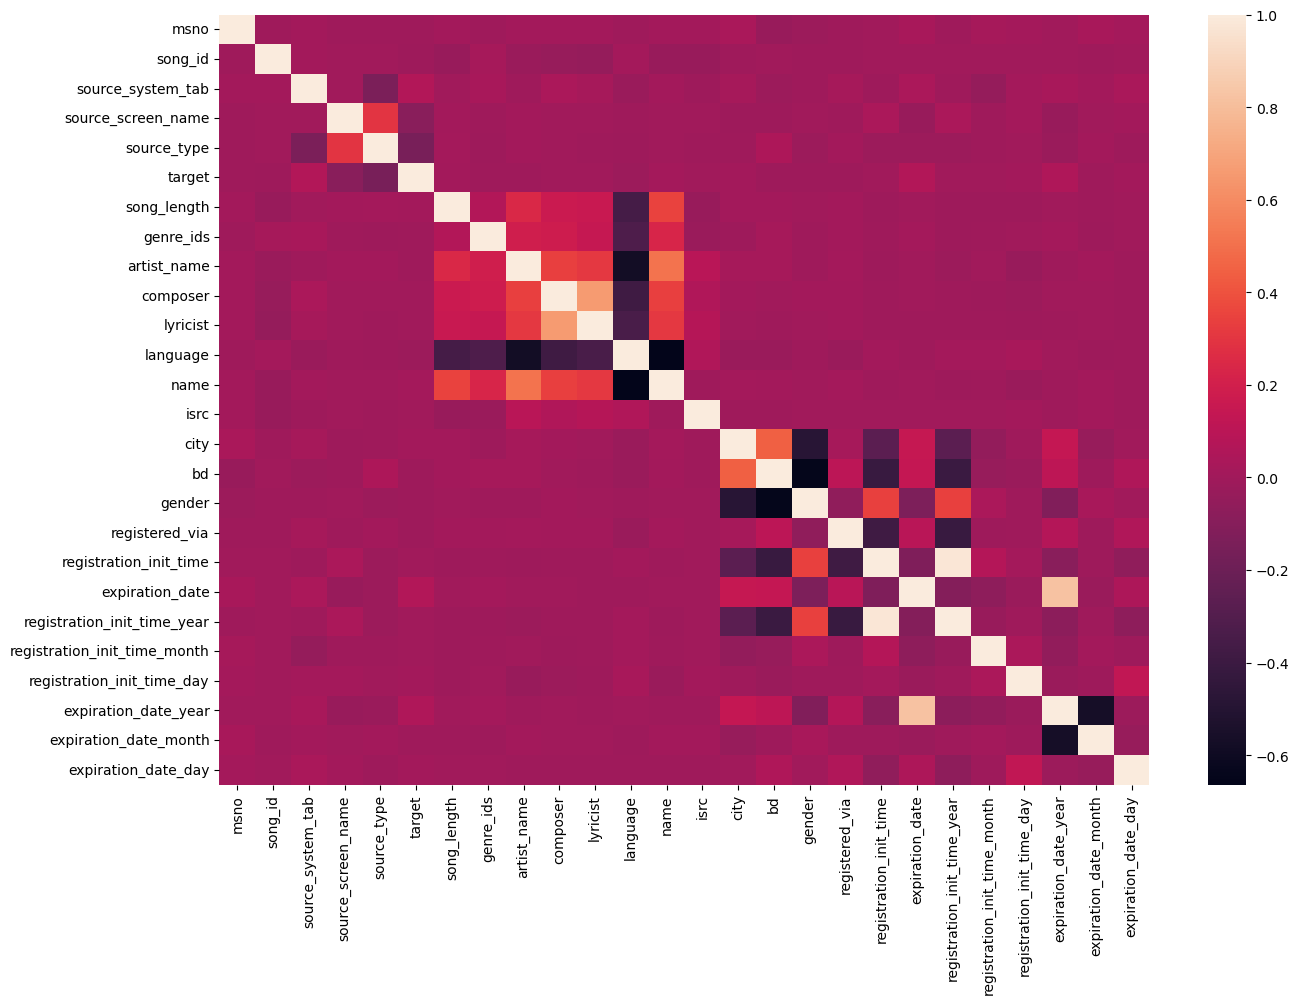

In [26]:
# Сorrelation matrix
plt.figure(figsize=[15,10])
sns.heatmap(songs.corr()) #annot = True
plt.show()

In [27]:
songs.describe()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
count,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000
mean,3079.591810,14416.529540,2.569390,7.67711,3.945100,0.750680,6232.60077,112.440300,3525.164170,6510.892350,3306.763890,3.14370,13193.451250,13640.684450,6.040950,11.906970,1.071210,1.950430,1555.901670,320.672210,8.604220,5.948900,14.916940,4.07103,7.553680,14.725470
std,1780.984103,8413.385948,1.481967,3.25317,1.616382,0.432622,2571.43277,33.763506,1692.339674,2713.134653,1225.708622,3.02452,6682.631025,6514.523847,6.152977,10.836898,0.834965,1.091533,736.151379,93.248558,2.980921,3.589718,8.686938,0.34688,2.311085,9.141669
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1537.750000,7155.000000,3.000000,7.00000,3.000000,1.000000,4245.75000,115.000000,2214.000000,4642.000000,3159.000000,1.00000,7695.000000,9461.750000,0.000000,1.000000,0.000000,1.000000,987.000000,305.000000,7.000000,3.000000,8.000000,4.00000,8.000000,7.000000
50%,3052.000000,14274.000000,3.000000,7.00000,4.000000,1.000000,6319.00000,118.000000,4099.000000,7664.000000,3159.000000,1.00000,14228.000000,13911.000000,3.000000,12.000000,1.000000,2.000000,1603.000000,320.000000,9.000000,6.000000,15.000000,4.00000,8.000000,14.000000
75%,4584.000000,21635.000000,3.000000,7.00000,5.000000,1.000000,8304.00000,118.000000,4884.000000,8391.000000,4028.000000,5.00000,18626.000000,18418.000000,11.000000,19.000000,2.000000,3.000000,2250.000000,329.000000,11.000000,9.000000,22.000000,4.00000,9.000000,22.000000
max,6196.000000,29078.000000,8.000000,18.00000,11.000000,1.000000,11808.00000,200.000000,5711.000000,10068.000000,5743.000000,10.00000,23891.000000,23398.000000,20.000000,64.000000,2.000000,4.000000,2620.000000,670.000000,12.000000,11.000000,30.000000,6.00000,11.000000,30.000000


In [28]:
songs.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target', 'song_length', 'genre_ids', 'artist_name',
       'composer', 'lyricist', 'language', 'name', 'isrc', 'city', 'bd',
       'gender', 'registered_via', 'registration_init_time', 'expiration_date',
       'registration_init_time_year', 'registration_init_time_month',
       'registration_init_time_day', 'expiration_date_year',
       'expiration_date_month', 'expiration_date_day'],
      dtype='object')

**These are the different columns present in the dataset.**

In [42]:
songs[ 'source_type'].unique()

array([ 5,  4,  3,  9,  0, 11,  8,  6,  7,  2,  1, 10])

In [44]:
#EDA

<AxesSubplot:xlabel='source_system_tab', ylabel='count'>

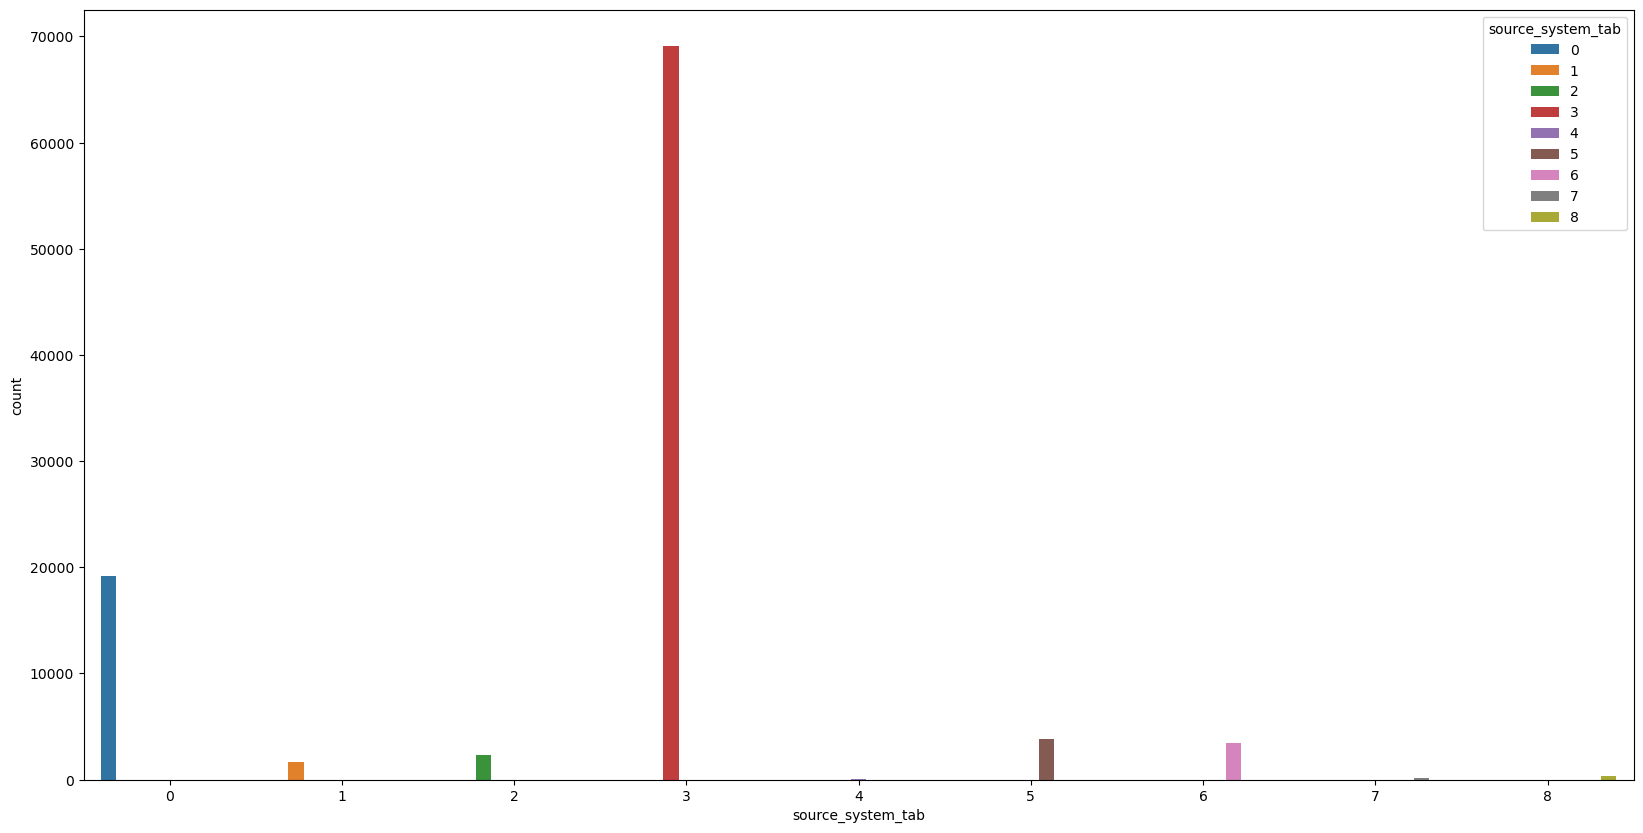

In [45]:
plt.figure(figsize=(20,10))
sns.countplot(x='source_system_tab', hue='source_system_tab', data=songs)

<AxesSubplot:xlabel='source_type', ylabel='count'>

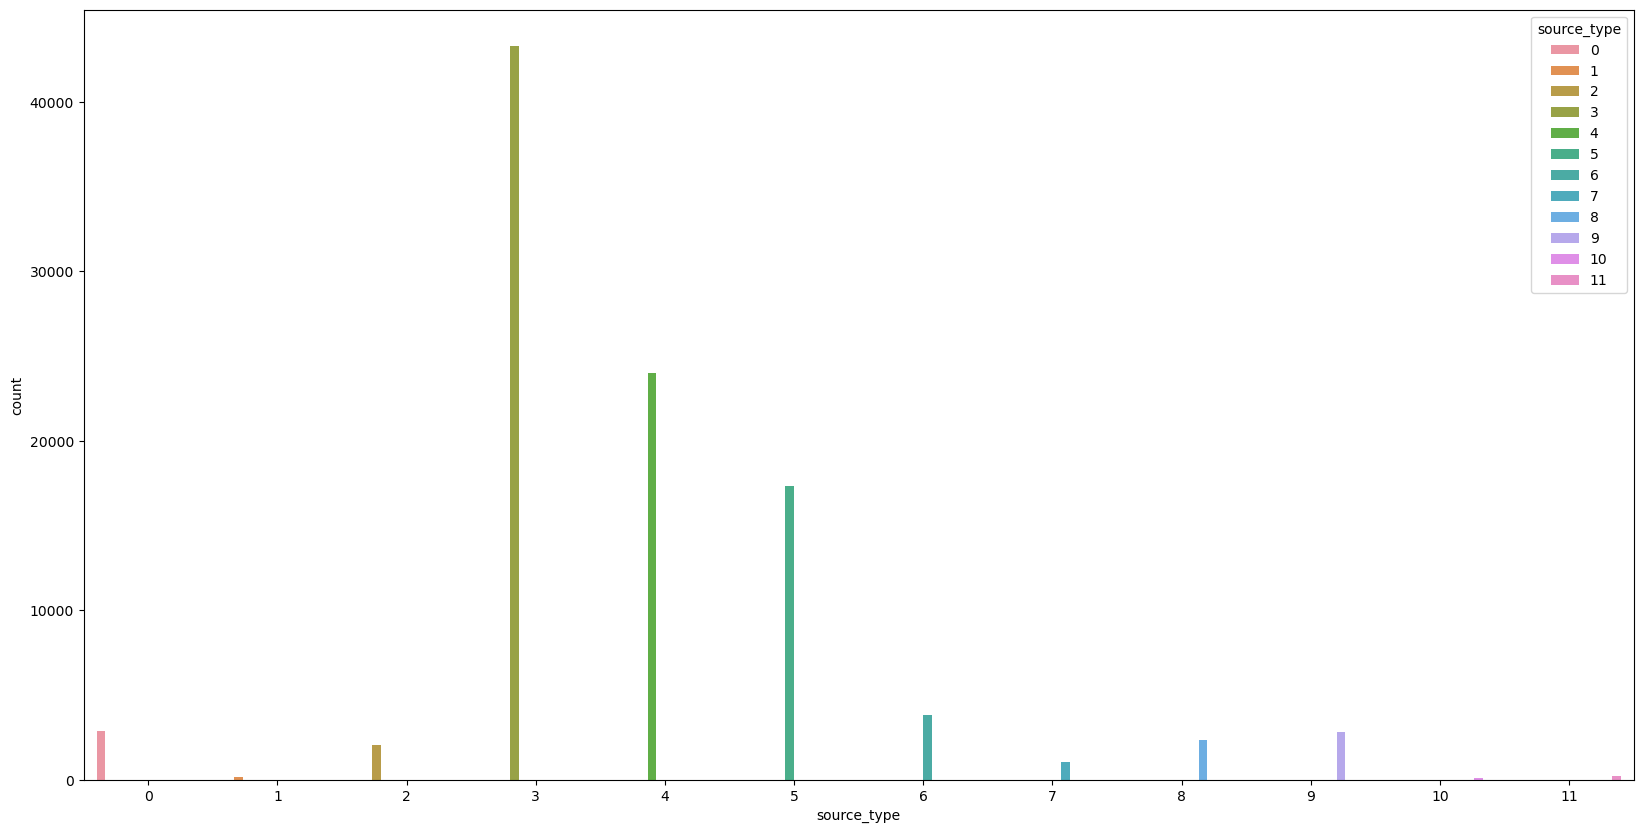

In [46]:
plt.figure(figsize=(20,10))
sns.countplot(x='source_type', hue='source_type', data=songs)

In [51]:
songs['gender'].unique()

array([2, 0, 1])

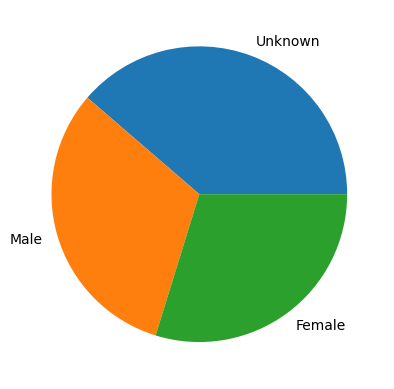

In [53]:
gen=['Unknown','Male','Female']
plt.pie(songs['gender'].value_counts(), labels = gen)
plt.show() 

In [41]:
#Model Fitting

In [29]:
X = songs.drop('target', axis = 1)
y = songs['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [39]:
def model_with(model_name, X_train, X_val, y_train, y_val) :
    print("==================================================")
    print("Modeling with :", model_name)
    print()
        
    if model_name == "Random Forest Classifier" :
        model = RandomForestClassifier(
            n_estimators=1000, 
        )
    elif model_name == "XGBoost Classifier" :
        model = xgb.XGBClassifier(
            n_estimators=1000, 
        )
    elif model_name == "LightGBM Classifier" :
        model = lgbm.LGBMClassifier(
            n_estimators=1000, 
        )
    else :
        print("Model not found in function.")
        
    model.fit(X_train, y_train)
    
    val_pred = model.predict(X_val)
    print(classification_report(y_val, val_pred))
    print()
    print("Accuracy :", accuracy_score(y_val, val_pred))
    print("ROC :", roc_auc_score(y_val, val_pred))
    
    print("==================================================")
    print()

In [40]:
models = ["Random Forest Classifier","XGBoost Classifier","LightGBM Classifier"]
for i in models :
    model_with(i, X_train, X_val, y_train, y_val)

Modeling with : Random Forest Classifier

              precision    recall  f1-score   support

           0       0.76      0.57      0.65      6176
           1       0.87      0.94      0.90     18824

    accuracy                           0.85     25000
   macro avg       0.82      0.75      0.78     25000
weighted avg       0.84      0.85      0.84     25000


Accuracy : 0.8492
ROC : 0.7547314474521557

Modeling with : XGBoost Classifier

              precision    recall  f1-score   support

           0       0.73      0.57      0.64      6176
           1       0.87      0.93      0.90     18824

    accuracy                           0.84     25000
   macro avg       0.80      0.75      0.77     25000
weighted avg       0.83      0.84      0.83     25000


Accuracy : 0.84132
ROC : 0.751783427726483

Modeling with : LightGBM Classifier

              precision    recall  f1-score   support

           0       0.75      0.54      0.63      6176
           1       0.86      0.9

**Random Forest Classifier Accuracy is 0.8492**

**XGBoost Classifier is 0.84132**
  
**LightGBM Classifier is 0.84176**

#  Thank you !